## New method for generating partial coherence phase screens

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids
import SimMLA.fields  as fields
from numpy.fft import fft, ifft, fftshift, ifftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


I am simulating a Gaussian Schell model beam using a technique described in [Xiao and Voelz, "Wave optics simulation approach for partial spatially coherent beams," Opt. Express 14, 6986-6992 (2006)](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-14-16-6986) and Chapter 9 of [Computational Fourier Optics: A MATLAB Tutorial](http://spie.org/Publications/Book/858456), which is also by Voelz. This workbook verifies that we can produce the same results for the partial spatial coherence simulation as presented on page 186 of Voelz's book.

Here I am breaking from Xiao and Voelz's implementation by decoupling the phase screen parameters \\( \sigma\_f \\) and \\( \sigma\_r \\).

## Build the coordinate system

In [2]:
numLenslets = 21    # Must be odd; corresponds to the number of lenslets in one dimension
lensletSize = 500   # microns
focalLength = 13700 # microns, lenslet focal lengths
fc          = 50000 # microns, collimating lens focal length

wavelength  = 0.642 # microns

subgridSize  = 20001 # Number of grid (or lattice) sites for a single lenslet
physicalSize = numLenslets * lensletSize # The full extent of the MLA

# dim = 1 makes the grid 1D
collGrid = grids.Grid(50001, 3000, wavelength, fc, dim = 1)
grid     = grids.GridArray(numLenslets, subgridSize, physicalSize, wavelength, focalLength, dim = 1, zeroPad = 3)

Now, the output from the telescope + diffuser may be generated by multiplying the focused Gaussian beam with a random phase mask from the Voelz code.

The input beam has a 4 mm waist (radius), but is focused by a telescope whose first lens has a focal length of 100 mm = 1e5 microns. [Using a Gaussian beam calculator](http://www.calctool.org/CALC/phys/optics/f_NA), this means that the focused beam has a waist diameter of \\( 2w = 10.2 \, \mu m \\) and a beam standard deviation of \\( \frac{5.1 \mu m}{\sqrt{2}} = 3.6 \mu m \\).

After multiplying the beam by the phase screen, the field is Fourier transformed by the second telescope lens with \\( f = 50 \, mm \\) to produce the field on the MLA.

In [3]:
Z0              = 376.73 # Impedance of free space, Ohms
power           = 100  # mW
beamStd         = 3.6  # microns
sigma_f         = 10   # diffuser, correlation length microns
sigma_r         = 1
fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W

beam     = lambda x: fields.GaussianBeamWaistProfile(fieldAmp, beamStd)(x) \
                   * fields.diffuserMask(sigma_f, sigma_r, collGrid)(x)

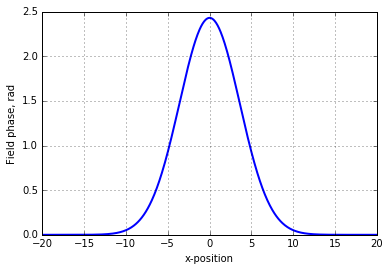

In [4]:
beamSample = beam(collGrid.px)

plt.plot(collGrid.px, np.abs(beamSample), linewidth = 2)
plt.xlim((-20,20))
plt.xlabel(r'x-position')
plt.ylabel(r'Field phase, rad')
plt.grid(True)
plt.show()

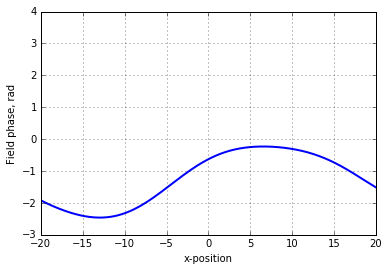

In [5]:
plt.plot(collGrid.px, np.angle(beamSample), linewidth = 2)
plt.xlim((-20,20))
plt.xlabel(r'x-position')
plt.ylabel(r'Field phase, rad')
plt.grid(True)
plt.show()

## Create the input field to the MLA's

The MLA inputs are the Fourier transform of this field when the diffuser is in the focal plane of the collimating lens.

In [6]:
scalingFactor = collGrid.physicalSize / (collGrid.gridSize - 1) / np.sqrt(collGrid.wavelength * collGrid.focalLength)
inputField    = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(beamSample)))

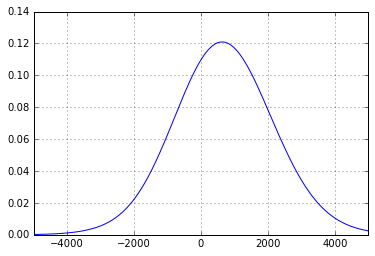

In [7]:
plt.plot(collGrid.pX, np.abs(inputField))
plt.xlim((-5000, 5000))
plt.grid(True)
plt.show()

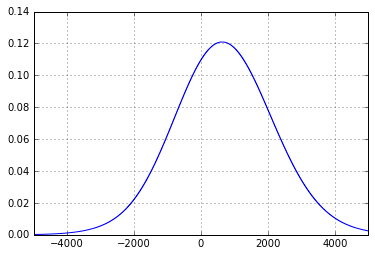

In [8]:
# Interpolate this field onto the MLA grid
mag = np.abs(inputField)
ang = np.angle(inputField)

inputMag = interp1d(collGrid.pX,
                    mag,
                    kind         = 'nearest',
                    bounds_error = False,
                    fill_value   = 0.0)
inputAng = interp1d(collGrid.pX,
                    ang,
                    kind         = 'nearest',
                    bounds_error = False,
                    fill_value   = 0.0)

plt.plot(grid.px, np.abs(inputMag(grid.px) * np.exp(1j * inputAng(grid.px))))
plt.xlim((-5000, 5000))
plt.grid(True)
plt.show()

In [21]:
field2 = lambda x: inputMag(x) * np.exp(1j * inputAng(x))

In [22]:
interpMag, interpAng = simfft.fftSubgrid(field2, grid)

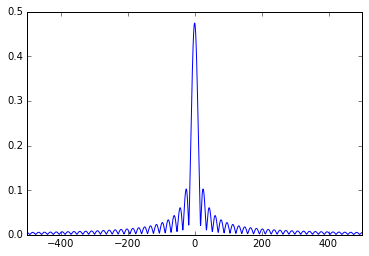

In [23]:
plt.plot(grid.pX, np.abs((interpMag[10](grid.pX)) * np.exp(1j *10000000* grid.pX)))
plt.xlim((-500, 500))
plt.show()

## Propagate this field through the dual MLA illuminator
The rest of this code is exactly the same as before: propagate the partially coherent beam through the illuminator and observe the irradiance pattern on the sample.

## Compute many realizations

In [11]:
fObj             = 3300   # microns

# Grid for interpolating the field after the second MLA
newGridSize = subgridSize * numLenslets # microns
newGrid     = grids.Grid(5*newGridSize, 5*physicalSize, wavelength, fObj, dim = 1)

In [12]:
%%time
nIter   = 10
#sigma_r = np.array([0.1, 0.3, 1, 3])
sigma_r = np.array([1])

# Create multiple sample irradiance patterns for various values of sigma_r
for sigR in sigma_r:
       
    # New phase mask
    beam     = lambda x: fields.GaussianBeamWaistProfile(fieldAmp, beamStd)(x) \
             * fields.diffuserMask(sigma_f, sigR, collGrid)(x)
        
    avgIrrad = np.zeros(newGrid.px.size, dtype=np.float128)
    for realization in range(nIter):
        print('sigma_r: {0:.2f}'.format(sigR))
        print('Realization number: {0:d}'.format(realization))

        scalingFactor = collGrid.physicalSize / (collGrid.gridSize - 1) / np.sqrt(collGrid.wavelength * collGrid.focalLength)
        afterColl     = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(beam(collGrid.px))))
        
        # Interpolate the input onto the new grid
        inputMag = interp1d(collGrid.pX,
                    np.abs(afterColl),
                    kind         = 'nearest',
                    bounds_error = False,
                    fill_value   = 0.0)
        inputAng = interp1d(collGrid.pX,
                    np.angle(afterColl),
                    kind         = 'nearest',
                    bounds_error = False,
                    fill_value   = 0.0)
        
        inputField = lambda x: inputMag(x) * np.exp(1j * inputAng(x))

        # Field propagation
        # Compute the interpolated fields
        # Every time inputField is called, a new phase mask is generated
        interpMag, interpPhase = simfft.fftSubgrid(inputField, grid)

        field   = np.zeros(newGrid.gridSize)

        # For each interpolated magnitude and phase corresponding to a lenslet
        # 1) Compute the full complex field
        # 2) Sum it with the other complex fields
        for currMag, currPhase in zip(interpMag, interpPhase):
            fieldMag   = currMag(newGrid.px)
            fieldPhase = currPhase(newGrid.px)

            currField = fieldMag * np.exp(1j * fieldPhase)
            field     = field + currField

        # Propagate the field in the BFP to the sample
        scalingFactor = newGrid.physicalSize / (newGrid.gridSize - 1) / np.sqrt(newGrid.wavelength * newGrid.focalLength)
        F             = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(field)))    

        # Compute the irradiance on the sample
        Irrad = np.abs(F)**2 / Z0 * 1000

        # Save the results for this realization
        avgIrrad = avgIrrad + Irrad

    # Average irradiance
    avgIrrad = avgIrrad / nIter

    # Save the results
    np.save('Rotating Diffuser Calibration/x-coords_sigR_{0:.3f}.npy'.format(sigR), newGrid.pX)
    np.save('Rotating Diffuser Calibration/avgIrrad_sigR_{0:.3f}.npy'.format(sigR), avgIrrad)

sigma_r: 1.00
Realization number: 0
sigma_r: 1.00
Realization number: 1
sigma_r: 1.00
Realization number: 2
sigma_r: 1.00
Realization number: 3
sigma_r: 1.00
Realization number: 4
sigma_r: 1.00
Realization number: 5
sigma_r: 1.00
Realization number: 6
sigma_r: 1.00
Realization number: 7
sigma_r: 1.00
Realization number: 8
sigma_r: 1.00
Realization number: 9
CPU times: user 6min 14s, sys: 2.69 s, total: 6min 16s
Wall time: 6min 16s


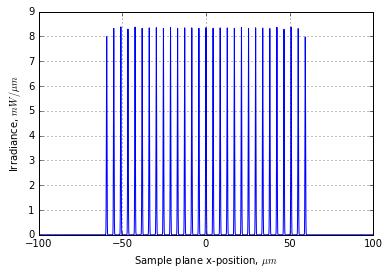

In [13]:
plt.plot(newGrid.pX, avgIrrad)
plt.xlim((-100,100))
plt.xlabel(r'Sample plane x-position, $\mu m$')
plt.ylabel(r'Irradiance, $mW / \mu m$')
plt.grid(True)
plt.show()

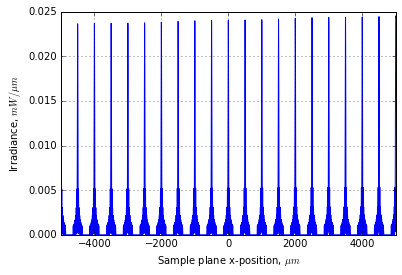

In [14]:
plt.plot(newGrid.px, np.abs(field))
plt.xlim((-5000,5000))
plt.xlabel(r'Sample plane x-position, $\mu m$')
plt.ylabel(r'Irradiance, $mW / \mu m$')
plt.grid(True)
plt.show()

In [72]:
# Check the output power
powerOut = simps(avgIrrad, newGrid.pX)
print('The output power is: {0:.2f}'.format(powerOut))

The output power is: 98.73
